In [17]:
from PIL import Image, ImageDraw, ImageFilter
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import random

%config InlineBackend.figure_format = 'retina'

In [18]:
class ShapesDataset(Dataset):
    def __init__(self, n_samples=200, size=224):
        self.n_samples = n_samples
        self.size = size
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return self.n_samples

    def _rand_color(self):
        # random pastel or bright color
        return tuple(np.random.randint(50, 255, 3))

    def _make_shape(self):
        size = self.size

        # random background color (light texture feel)
        bg_color = tuple(np.random.randint(0, 100, 3))
        img = Image.new('RGB', (size, size), bg_color)
        mask = Image.new('L', (size, size), 0)
        draw_img = ImageDraw.Draw(img)
        draw_mask = ImageDraw.Draw(mask)

        shape = np.random.choice(['circle', 'square'])
        margin = size // 8
        min_extent = size // 8
        max_extent = size // 4

        cx = np.random.randint(margin, size - margin)
        cy = np.random.randint(margin, size - margin)
        half = np.random.randint(min_extent, max_extent)

        # random color and slight blur or transparency
        shape_color = self._rand_color()
        alpha = random.uniform(0.7, 1.0)

        if shape == 'circle':
            draw_img.ellipse((cx-half, cy-half, cx+half, cy+half), fill=shape_color)
            draw_mask.ellipse((cx-half, cy-half, cx+half, cy+half), fill=1)
        else:
            draw_img.rectangle((cx-half, cy-half, cx+half, cy+half), fill=shape_color)
            draw_mask.rectangle((cx-half, cy-half, cx+half, cy+half), fill=1)

        # add random Gaussian noise / blur to background
        if np.random.rand() < 0.5:
            img = img.filter(ImageFilter.GaussianBlur(radius=np.random.uniform(0, 1.5)))

        # overlay random noise to make it look less perfect
        np_img = np.array(img).astype(np.float32)
        noise = np.random.randn(*np_img.shape) * 10  # light noise
        np_img = np.clip(np_img + noise, 0, 255).astype(np.uint8)
        img = Image.fromarray(np_img)

        img = self.to_tensor(img)
        mask = torch.tensor(np.array(mask), dtype=torch.long)
        return img, mask

    def __getitem__(self, idx):
        return self._make_shape()


In [21]:
from torch.utils.data import DataLoader

train_dataset = ShapesDataset(n_samples=100, size=224)
test_dataset  = ShapesDataset(n_samples=20, size=224)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=8, shuffle=False)

Text(0.5, 1.0, 'Masks')

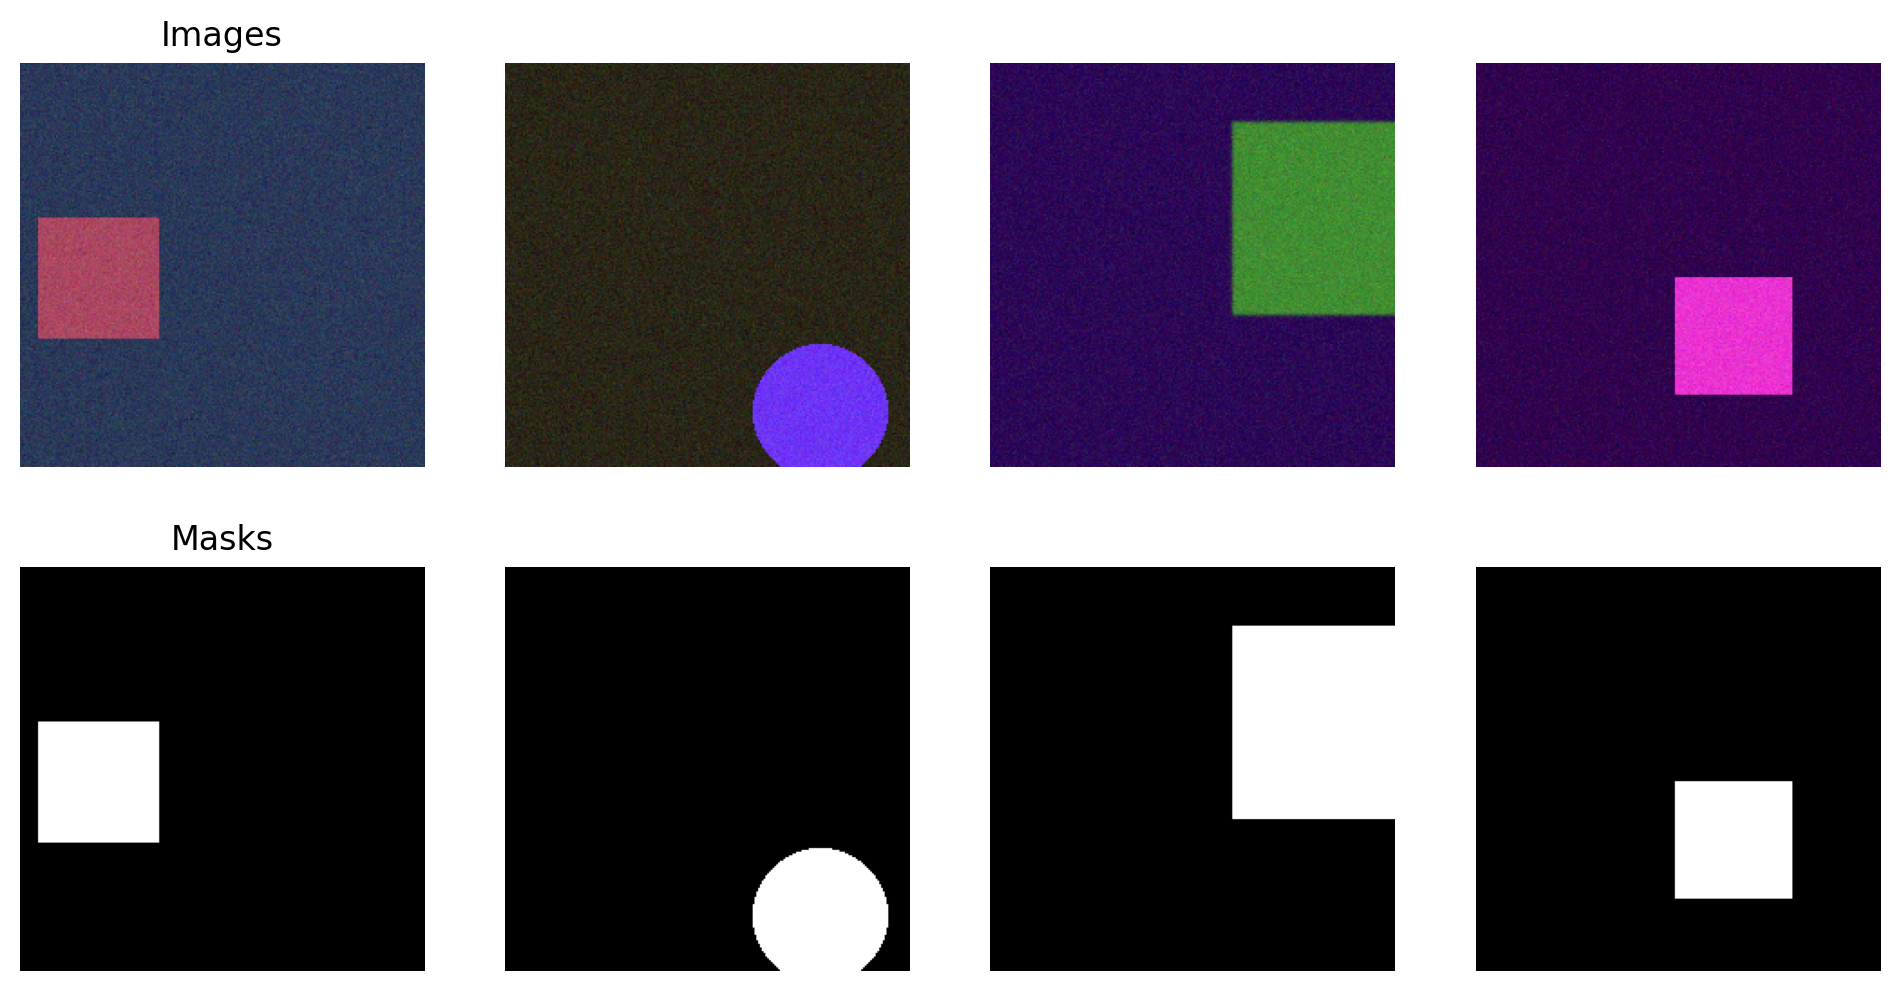

In [22]:
import matplotlib.pyplot as plt

imgs, masks = next(iter(train_loader))
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i in range(4):
    axes[0, i].imshow(imgs[i].permute(1, 2, 0))
    axes[0, i].axis('off')
    axes[1, i].imshow(masks[i], cmap='gray')
    axes[1, i].axis('off')

axes[0, 0].set_title('Images')
axes[1, 0].set_title('Masks')

In [23]:
import os
import json

def save_shapes_dataset(
    root="shapes224",
    n_train=200,
    n_test=50,
    size=224,
    seed=42
):
    os.makedirs(root, exist_ok=True)
    np.random.seed(seed)
    torch.manual_seed(seed)

    splits = {"train": n_train, "test": n_test}
    dataset = ShapesDataset(n_samples=n_train + n_test, size=size)

    metadata = {}
    idx = 0

    for split, n_samples in splits.items():
        img_dir = os.path.join(root, split, "images")
        mask_dir = os.path.join(root, split, "masks")
        os.makedirs(img_dir, exist_ok=True)
        os.makedirs(mask_dir, exist_ok=True)

        for _ in range(n_samples):
            img, mask = dataset[idx]
            idx += 1

            img_pil = transforms.ToPILImage()(img)
            mask_pil = Image.fromarray(mask.numpy().astype("uint8"))

            img_name = f"{idx:04d}.png"
            mask_name = f"{idx:04d}.png"

            img_path = os.path.join("images", img_name)
            mask_path = os.path.join("masks", mask_name)

            img_pil.save(os.path.join(root, split, img_path))
            mask_pil.save(os.path.join(root, split, mask_path))

            metadata.setdefault(split, []).append({
                "image": img_path,
                "mask": mask_path,
                "width": size,
                "height": size
            })

    # save metadata
    meta_path = os.path.join(root, "metadata.json")
    with open(meta_path, "w") as f:
        json.dump(metadata, f, indent=2)
    print(f"Saved dataset to {root}/ with metadata.json")

In [24]:
save_shapes_dataset(root="shapes224", n_train=1000, n_test=1000)

Saved dataset to shapes224/ with metadata.json


In [25]:
class ShapesDiskDataset(Dataset):
    def __init__(self, root="shapes224", split="train", transform=None, target_transform=None):
        self.root = root
        self.split = split
        self.transform = transform or transforms.ToTensor()
        self.target_transform = target_transform
        self.meta_path = os.path.join(root, "metadata.json")
        with open(self.meta_path, "r") as f:
            metadata = json.load(f)
        self.samples = metadata[split]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        img_path = os.path.join(self.root, self.split, sample["image"])
        mask_path = os.path.join(self.root, self.split, sample["mask"])

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        img = self.transform(img)
        mask = torch.tensor(np.array(mask), dtype=torch.long)
        return img, mask

Train samples: 1000


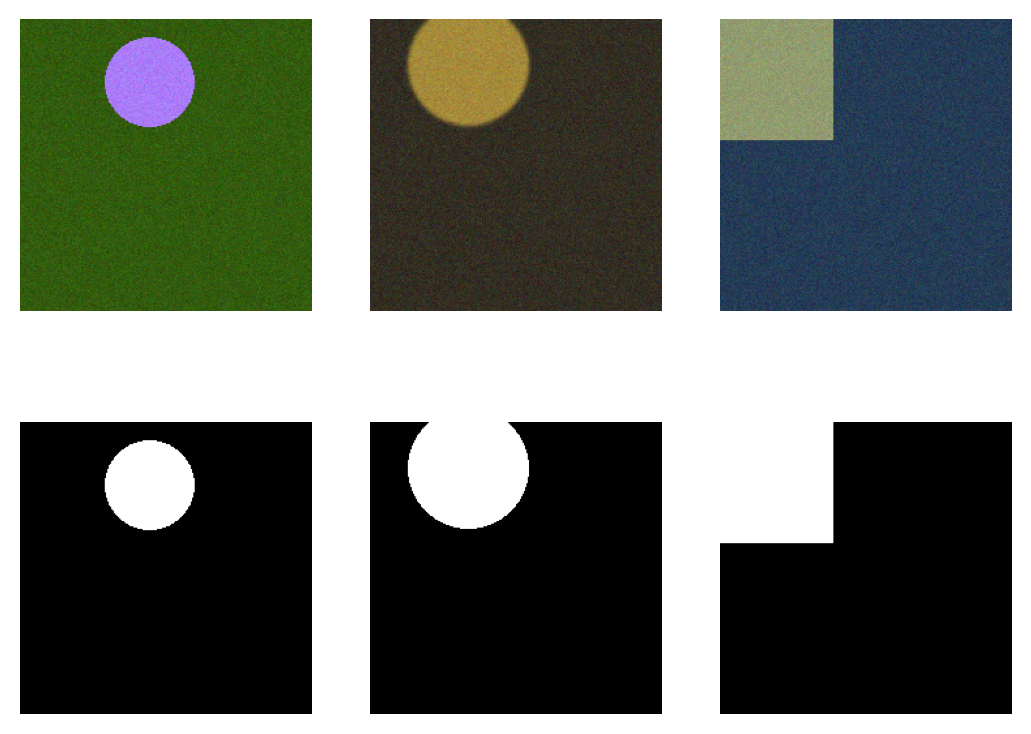

In [26]:
train_dataset = ShapesDiskDataset(root="shapes224", split="train")
print(f"Train samples: {len(train_dataset)}")

for i in range(3):
    img, mask = train_dataset[i]
    plt.subplot(2,3,i+1)
    plt.imshow(img.permute(1,2,0))
    plt.axis('off')
    plt.subplot(2,3,i+4)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
plt.show()